In [99]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import gzip

### Dati per il modello

Dal dataset iniziale `ModCloth` andiamo ad estrarre le variabili 'user_name', 'item_id' e 'quality'. Con queste tre variabili andremo ad allenare un modello per il nostro Recommandetion System che ci darà la possibilità di consigliare ad un utente degli item che potrebbero interessargli, in base agli acquisti che ha fatto in precedenza ed ha recensito.

In [100]:
from surprise import Reader, Dataset, KNNBasic

In [172]:
ModCloth = pd.read_csv('data/ModCloth_clear.csv')

# Consideriamo come user ID la variabile user_name poichè presenta meno valori unici nel dataset.
len(ModCloth.user_id.unique()) # --> 47176
len(ModCloth.user_name.unique()) # --> 31883

df = ModCloth[['user_name', 'item_id', 'quality']]
df.columns = ['user_id', 'item_id', 'rating']

L'intero dataset pulito è formato da circa 80 mila righe: all'interno sono recensiti 1364 item da 31883 utenti differenti. Per motivi computazionali andremo a considerare solo gli utenti che hanno un numero di recensioni superiore ad una certa soglia per i seguenti motivi:
- dovendo riempire la matrice di rating con i valori predetti del modello avremmo bisogno di troppo spazio in memoria quindi abbiamo bisogno di un campione più piccolo;
- anche se non in maniera del tutto corretta, possiamo andare a restituire delle raccomandazioni per l'acquisto di altri prodotti considerando solo gli utenti che hanno fatto molte recensioni; questo ci permette di avere delle raccomandazione specifiche per l'utente: andando infatti a considerare utenti con pochissime recensioni sorge il problema di mancanza di utenti simili poichè si hanno pochi valori per fare il confronto e il nostro modello andrebbe a suggerire dei prodotti in maniera quasi randomica.

Fatte queste considerazioni andiamo a considerare solo gli utenti con più di 100 recensioni.

In [173]:
# Estrazione utenti con più di 100 recensioni.
best_users = df.groupby('user_id').count().item_id[df.groupby('user_id').count().item_id > 100].index
df_sample = df[df.user_id.isin(best_users)]

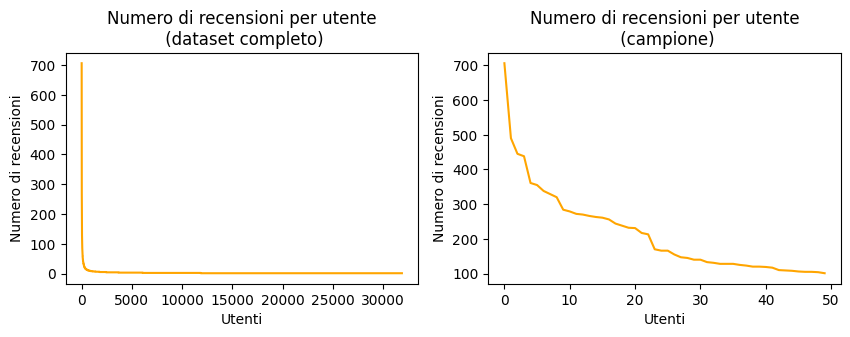

In [174]:
# Plot del numero di recensioni per utente.
fig = plt.figure(figsize = (10,3))

n_review = df.groupby('user_id').count().item_id
ax = fig.add_subplot(1,2,1)
ax.plot(sorted(n_review.to_list(), reverse=True), color = 'orange')
ax.set_title('Numero di recensioni per utente\n (dataset completo)')
ax.set_xlabel('Utenti')
ax.set_ylabel('Numero di recensioni')

n_review = df_sample.groupby('user_id').count().item_id
ax = fig.add_subplot(1,2,2)
ax.plot(sorted(n_review.to_list(), reverse=True), color = 'orange')
ax.set_title('Numero di recensioni per utente\n (campione)')
ax.set_xlabel('Utenti')
ax.set_ylabel('Numero di recensioni')

plt.show()

Vediamo come l'andamento, anche se consideriamo solo utenti con molte recensioni, tende ad essere simile per l'intero dataset e per il campione considerato.

In [175]:
# Modelliamo il dataset per renderlo utilizzabile per allenare il nostro modello (K-NN).
reader = Reader(rating_scale=(df_sample.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df_sample, reader)

### (2) Ricerca dei migliori valori degli iperparametri

In [176]:
from surprise.model_selection import cross_validate

Ricerchiamo i valori degli iperparametri che meglio ottimizzano il modello in base ai nostri dati, valutando le varie conbinazioni sulla base del RMSE (Root Mean Square Error).
Gli iperparametri che consideriamo sono:
- **k**: numero di vicini da considerare
- **name**: metrica per misurare la distanza tra gli utenti
- **user_based**: user_based o item_based

Per fare questa analisi utilizziamo costruiamo una grid search: dati diversi valori degli iperparametri considerati proviamo tutte le combinazioni possibili ottimizzandole tramite cross validation per cui settiamo un valore pari a 3.

In [177]:
# Settiamo i valori degli iperparametri che vogliamo testare.
similarity = ['msd', 'cosine', 'pearson', 'pearson_baseline']
k_grid = np.arange(1,30) 
user_based = [False, True]

res = {}

for based in user_based:
    res = {}
    for pos,s in tqdm(enumerate(similarity)):
        RMSE = []
        MSE = []
        for k in k_grid:
            sim_options = {
                "k": k,
                "name": s,
                "user_based": based, 
            }

            # Per ogni combinazione valutiamo il modello.
            model = KNNBasic(sim_options = sim_options)
            results = cross_validate(model, data, measures=['RMSE', 'MSE'], cv=3, verbose=0, n_jobs=-1)
            RMSE.append(np.mean(results['test_rmse']))
            MSE.append(np.mean(results['test_mse']))
            
        res[s] = (k_grid[np.argmin(RMSE)], min(MSE), min(RMSE))

    results = pd.DataFrame(res, index=['k', 'MSE', 'RMSE'])
    display(results.style.set_caption(f"user_based = {based}"))
    
    # Salviamo i valori che ottimizzano meglio il modello.
    new_k = int(results.loc['k'][np.argmin(results.loc['RMSE'])])
    new_metric = results.columns[np.argmin(results.loc['RMSE'])]
    new_based = based
    new_best_rmse = results[new_metric].loc['RMSE']
    new_best_mse = results[new_metric].loc['MSE']
    if based:
        if new_best_rmse < best_rmse:
            best_k = new_k
            best_metric = new_metric
            best_based = new_based
            best_rmse = new_best_rmse
            best_mse = new_best_mse
    else:
        best_k = new_k
        best_metric = new_metric
        best_based = new_based
        best_rmse = new_best_rmse
        best_mse = new_best_mse

print(f"Scegliamo i seguenti valori per gli iperparametri:\n- k: {best_k}\n- name: {best_metric}\n- user_based: {best_based}\n")
print(f"RMSE: {best_rmse}, MSE: {best_mse}")

4it [01:23, 20.85s/it]


,msd,cosine,pearson,pearson_baseline
k,26.000000,4.000000,6.000000,21.000000
MSE,0.956018,0.964659,1.014337,1.024635
RMSE,0.977689,0.982151,1.007024,1.012214


4it [00:28,  7.10s/it]


,msd,cosine,pearson,pearson_baseline
k,24.000000,20.000000,27.000000,8.000000
MSE,0.916445,0.912823,0.969571,1.095919
RMSE,0.957295,0.955368,0.984566,1.046849


Scegliamo i seguenti valori per gli iperparametri:
- k: 20
- name: cosine
- user_based: True

RMSE: 0.955368356843494, MSE: 0.9128234286748153


### (3) Train del modello e filling della matrice di rating

Utilizziamo ora i valori ottimali trovati per allenare il nostro modello e fare successivamente delle previsioni, andando così a riempire la *matrice di rating*.

In [178]:
# Estraiamo gli ID di tutti gli utenti e di tutti i prodotti.
unique_users = df_sample.user_id.unique()
unique_users.sort()
unique_items = df_sample.item_id.unique()
unique_items.sort()

# Alleniamo il modello con i valori ottimali trovati in precedenza.
trainset = data.build_full_trainset()
sim_options = {
    "k": best_k,
    "name": best_metric,
    "user_based": best_based, 
}
model = KNNBasic(sim_options = sim_options) 
model.fit(trainset)

# Chiediamo al modello di prevedere la valutazione di ogni utente ad ogni item.
test_set = [[user, item, 3] for user in tqdm(unique_users) for item in unique_items]
pred = [model.predict(i[0], i[1]).est for i in tqdm(test_set)]

# Riempiamo la matrice di rating con i valori predetti.
rating_matrix = np.reshape(pred, (len(unique_users), len(unique_items)))
rating_dataframe = pd.DataFrame(rating_matrix, columns=unique_items, index=unique_users)
print("Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item")
rating_dataframe.head(20)

Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|██████████| 32550/32550 [00:00<00:00, 70047.10it/s]

Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item


,123373,124124,124761,125442,125602,126560,126885,129268,130225,130424,...,803464,803768,804295,805172,805642,806479,806856,807252,807384,807722
Allison,4.833214,3.928434,4.666822,4.150556,5.0,3.801804,3.874394,3.898149,3.626473,3.665898,...,3.826461,3.531407,5.0,4.751633,3.242259,4.171680,4.449598,4.0,3.997961,3.750234
Alyssa,4.833627,3.929366,4.665354,4.048922,5.0,3.806246,3.950390,3.897275,3.622284,3.667318,...,3.825984,3.531743,5.0,4.749172,3.245215,4.348761,4.649150,4.0,4.000994,3.751589
Amanda,4.833073,3.929878,4.671782,3.921495,5.0,3.799843,3.951167,3.898147,3.622059,3.664279,...,3.826621,3.533128,5.0,4.749832,3.249101,4.527495,4.423499,4.0,3.999095,3.749862
Amber,4.832000,3.927804,4.665472,4.076679,5.0,3.801867,3.853304,3.901700,3.622633,3.661890,...,3.826802,3.533433,5.0,4.749113,3.246212,4.324278,4.446790,4.0,4.001114,3.739405
Amy,4.832748,3.932105,4.665092,4.075877,5.0,3.797359,3.950712,3.897897,3.625490,3.665092,...,3.824935,3.532455,5.0,4.750506,3.251126,4.374909,4.599752,4.0,3.999457,3.751520
Andrea,4.833448,3.930874,4.665168,4.150381,5.0,3.802877,4.000950,3.896885,3.625734,3.662424,...,3.826561,3.534282,5.0,4.749816,3.246709,4.425876,4.625078,4.0,4.000157,3.756689
Angela,4.834276,3.930649,4.665484,4.199639,5.0,3.800418,3.926776,3.898407,3.624538,3.662548,...,3.826409,3.531229,5.0,4.745273,3.250431,4.374996,4.474970,4.0,3.996977,3.749523
Anna,4.833004,3.930343,4.664617,4.049901,5.0,3.801317,4.026217,3.897372,3.629764,3.664292,...,3.825812,3.528432,5.0,4.750223,3.245399,4.323950,4.451152,4.0,3.997945,3.751968
Ashley,4.832212,3.928731,4.665552,4.153195,5.0,3.800106,3.849236,3.898193,3.625715,3.679211,...,3.826568,3.539681,5.0,4.750160,3.249682,4.499255,4.599777,4.0,4.000827,3.751986
Brittany,4.833364,3.929698,4.665741,3.998453,5.0,3.802018,3.925844,3.898039,3.625401,3.660533,...,3.826443,3.531547,5.0,4.747558,3.250187,4.400060,4.550703,4.0,3.999682,3.748399


Se non ci sono abbastanza vicini viene assegnato al valore della predizione la media globale di tutti i rating. Il valore minimo di vicini minimi è settato di default a 1.

In [179]:
# Media globale dei rating.
trainset.global_mean

3.9736915496885747

### (4) Segmentazione degli utenti in base alle preferenze

In [180]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Calcoliamo la distanza tra gli utenti tramite la *Cosine Similarity* (df_cosine) e cerchiamo il numero ottimale di cluster in cui raggrupparli data questa matrice di similarità usando l'**Elbow Method**.

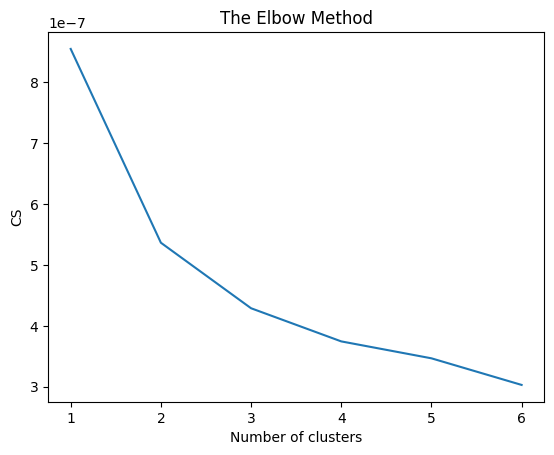

In [185]:
# Calcolo delle cosine similarity tra gli utenti.
df_cosine=pd.DataFrame(cosine_similarity(rating_dataframe, dense_output=True))

# Elbow Method.
cs = []
range_k = list(range(1,7))
for i in range_k:
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_cosine)
    cs.append(kmeans.inertia_)
    
plt.plot(range_k, cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Come valore di k andreamo a prendere il punto in cui la curva forma un gomito: usiamo perciò 2 cluster.

Andando a considerare le prime due componenti principali applichiamo poi l'algoritmo K-Means per raggruppare gli utenti simili tra loro rappresentandoli graficamente.

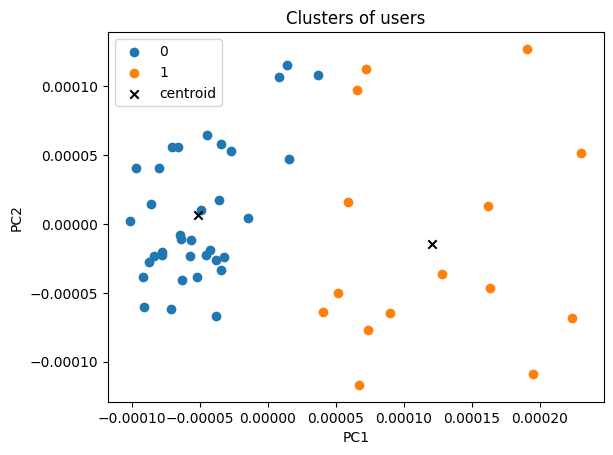

In [186]:
# Prime 2 componenti principali.
data = df_cosine
pca = PCA(2)
transform = pca.fit_transform(data)

# KMeans con valore di k precedentemente trovato.
k = 2
kmeans = KMeans(n_clusters = k)
label = kmeans.fit_predict(transform)
u_labels = np.unique(label)

# Plot dei cluster.
plt.figure()
for i in u_labels:
    plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='black',marker='x',label='centroid')
plt.legend()
plt.title('Clusters of users')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

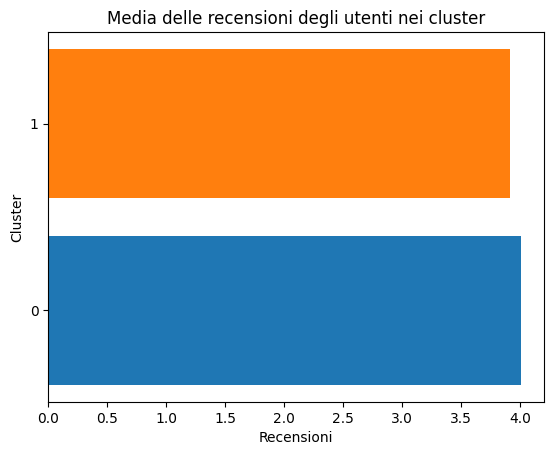

In [187]:
label_kmeans = pd.DataFrame({'user_id' : rating_dataframe.index, 'label': label})
avg_review_0 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 0].user_id)].groupby('user_id').mean().rating.mean()
avg_review_1 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 1].user_id)].groupby('user_id').mean().rating.mean()

cluster = [0, 1]
plt.barh(cluster, [avg_review_0, avg_review_1], color = ['tab:blue', 'tab:orange'])
plt.yticks(cluster)
plt.xlabel('Recensioni')
plt.ylabel('Cluster')
plt.title('Media delle recensioni degli utenti nei cluster');

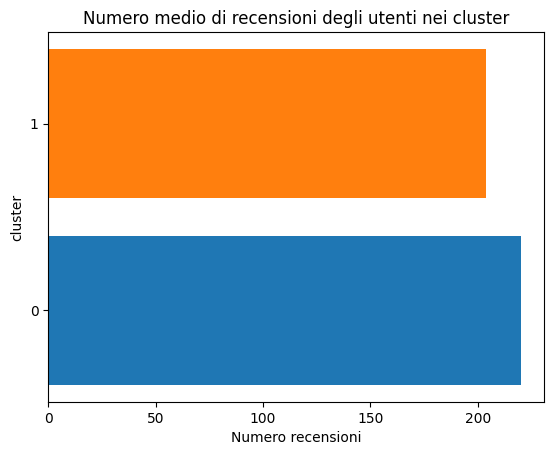

In [188]:
avg_review_0 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 0].user_id)].groupby('user_id').count().item_id.mean()
avg_review_1 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 1].user_id)].groupby('user_id').count().item_id.mean()

plt.barh(cluster, [avg_review_0, avg_review_1], color = ['tab:blue', 'tab:orange'])
plt.yticks(cluster)
plt.ylabel('cluster')
plt.xlabel('Numero recensioni')
plt.title('Numero medio di recensioni degli utenti nei cluster');

Notiamo dai grafici sovrastanti come il valore medio delle recensioni cambia di poco tra i due gruppi mentre si ha una differenza leggermente maggiore per quanto riguarda la quantità media di recensioni per utente.

### (5) N item da consigliare ad ogni utente

Creiamo una funzione che restituisce una lista di n item ordinata per il valore del rating predetto: vengono riportati solo gli item che l'utente non ha recensito già. 

In [155]:
def top_n_recommendation(user_id, ratings_df, n_items, all_users = False):

    # Controllo se l'utente esiste nella nostra lista.
    users_id = ratings_df["user_id"].unique()
    if user_id not in users_id:
        return('This users do not exist')

    # Consideriamo solo item non recensiti dall'utente.
    items_id = ratings_df["item_id"].unique()
    item_ids_user = ratings_df.loc[df["user_id"] == user_id, "item_id"]
    item_ids_to_pred = np.setdiff1d(items_id, item_ids_user)

    # Estraiamo i valori predetti.
    test_set = [[user_id, item, 3] for item in item_ids_to_pred]
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])

    # Riportiamo i top n item con miglior rating predetto.
    index_max = (-pred_ratings).argsort()[:n_items]
    
    if not all_users:
        print("Top {0} item recommendations for user {1}:".format(n_items, user_id))
        for i in index_max:
            item_id = items_id[i]
            print(f'Item: {item_id} rating: {pred_ratings[i]}')
    else:
        return [items_id[i] for i in index_max]

Inserendo un utente (di quelli presenti nel nostro campione) come input della funzione, verranno restituiti n_item consigliati ordinati per rating predetto.

In [78]:
unique_users

array(['Allison', 'Alyssa', 'Amanda', 'Amber', 'Amy', 'Andrea', 'Angela',
       'Anna', 'Ashley', 'Brittany', 'Caitlin', 'Catherine', 'Christina',
       'Christine', 'Courtney', 'Danielle', 'Elizabeth', 'Emily', 'Erin',
       'Hannah', 'Heather', 'Jen', 'Jennifer', 'Jessica', 'Julie', 'Kate',
       'Katherine', 'Katie', 'Kelly', 'Kimberly', 'Kristen', 'Laura',
       'Lauren', 'Lindsay', 'Lindsey', 'Lisa', 'Mary', 'Megan', 'Meghan',
       'Melissa', 'Michelle', 'Molly', 'Nicole', 'Rachel', 'Rebecca',
       'Samantha', 'Sara', 'Sarah', 'Shannon', 'Stephanie'], dtype=object)

In [87]:
user = 'Sarah'
n_items = 10

top_n_recommendation(user, df_sample, n_items)

Top 10 item recommendations for user Sarah:
Item: 488987 rating: 5.0
Item: 509537 rating: 5.0
Item: 208814 rating: 5.0
Item: 453244 rating: 5.0
Item: 204815 rating: 5.0
Item: 294941 rating: 5.0
Item: 299027 rating: 5.0
Item: 452244 rating: 5.0
Item: 306037 rating: 5.0
Item: 199300 rating: 5.0


Calcoliamo quindi i top n item da consigliare ai singoli utenti. Vediamo come, grazie al numero elevato di recensioni che gli utenti considerati hanno fatto, riusciamo a dare raccomandazioni per l'acquisto di nuovi prodotti personalizzate per ogni utente (le righe hanno valori differenti).

In [156]:
n_items = 5

list_n_item = [top_n_recommendation(user, df_sample, n_items, all_users=True) for user in tqdm(unique_users)];
recommended_matrix = np.reshape(list_n_item, (len(unique_users), n_items))
rating_dataframe = pd.DataFrame(recommended_matrix, columns=list(range(0,n_items)), index=unique_users)
rating_dataframe.transpose()

100%|██████████| 50/50 [00:00<00:00, 94.97it/s] 


,Allison,Alyssa,Amanda,Amber,Amy,Andrea,Angela,Anna,Ashley,Brittany,...,Michelle,Molly,Nicole,Rachel,Rebecca,Samantha,Sara,Sarah,Shannon,Stephanie
0,194376,445254,250941,645769,407072,649751,357815,209540,402677,645536,...,520945,535072,169727,167400,221693,407072,453135,243416,407072,397224
1,216517,217181,248558,340881,216517,217308,285967,225922,217181,285967,...,320025,538258,210722,327330,409758,677323,216517,488987,363927,268252
2,530472,654079,509537,217181,215150,352119,290868,633619,391519,654079,...,655211,216517,393265,553743,409228,674375,215150,245855,204815,276941
3,363423,655211,255393,680903,210299,545232,294941,230029,215150,299027,...,627861,454030,396846,207493,231648,208814,276941,248558,365070,277758
4,362516,210722,503264,682698,399672,215150,299027,628711,210722,301053,...,199300,210722,397005,548570,408303,668800,420800,253699,202255,278772


### (6) Filling della matrice di rating tramite Matrix Factorization

Per questo punto andremo ad utilizzare come algoritmo basato sul *Matrix Factorization* il **SVD**(Single Value Decomposition).

In [157]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

In [158]:
# Adattiamo i nostri dati in modo da renderli utilizzabili per il modello (SVD).
reader = Reader(rating_scale=(df_sample.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df_sample, reader)

Andiamo a ricercare i valori degli iperparametri che ottimizzano il modello con la funzione *GridSearchCV*. Alcuni dei valori che andremo a testare sono relativi agli iperparametri *numero di fattori*, *numero di epoch*, *learning rate* e *regolarizzazione dei parametri*.

In [162]:
grid = {'n_factors':[50, 100, 150],
        'n_epochs': [5, 10, 20, 30], 
        'lr_all': [.0025, .005, .001, .01],
        'reg_all':[0.02,0.1]}

gs = GridSearchCV(SVD, grid, measures=['RMSE', 'MSE'], cv=3)
gs.fit(data)

best_n_factors = gs.best_params['rmse']['n_factors']
best_n_epochs = gs.best_params['rmse']['n_epochs']
best_lr = gs.best_params['rmse']['lr_all']
best_reg = gs.best_params['rmse']['reg_all']

print(f"Scegliamo i seguenti valori per gli iperparametri:\n- n_factors: {best_n_factors}\n- n_epochs: {best_n_epochs}\n- lr_all: {best_lr}\n- reg_all: {best_reg}")
print(f"RMSE: {gs.best_score['rmse']}, MSE: {gs.best_score['mse']}")

Scegliamo i seguenti valori per gli iperparametri:
- n_factors: 50
- n_epochs: 30
- lr_all: 0.0025
- reg_all: 0.1
RMSE: 0.9431725905039204, MSE: 0.8896732344388042


Trovati i valori che ottimizzano il nostro modello andiamo ad allenarlo e a riempire la *matrice di rating* seguendo i passi fatti per il modello precedente.

In [165]:
unique_users = df_sample.user_id.unique()
unique_users.sort()
unique_items = df_sample.item_id.unique()
unique_items.sort()

# Training del modello.
trainset = data.build_full_trainset()

model = SVD(n_factors=best_n_factors, n_epochs=best_n_epochs, lr_all=best_lr, reg_all=best_reg)
model.fit(trainset)

test_set = [(user, item) for user in unique_users for item in unique_items]
pred = [model.predict(i[0], i[1]).est for i in test_set]

rating_matrix = np.reshape(pred, (len(unique_users), len(unique_items)))
rating_dataframe = pd.DataFrame(rating_matrix, columns=unique_items, index=unique_users)
print("Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item")
rating_dataframe.head(20)

Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item


,123373,124124,124761,125442,125602,126560,126885,129268,130225,130424,...,803464,803768,804295,805172,805642,806479,806856,807252,807384,807722
Allison,4.209102,3.982464,4.137094,4.148870,4.106542,3.863425,4.010299,3.955597,3.729701,3.909434,...,3.862623,3.715912,4.160730,4.376145,3.788658,4.295680,4.357260,3.987240,4.030917,3.847459
Alyssa,4.313996,4.045939,4.318836,4.243195,4.221654,4.079459,4.118529,4.133896,3.857243,4.116317,...,4.005787,3.945031,4.214852,4.517919,4.004271,4.480043,4.557018,4.171273,4.082254,4.077794
Amanda,4.240671,3.934882,4.150428,4.101483,4.062003,3.866841,3.942104,3.873427,3.699801,3.902560,...,3.844285,3.686828,4.081339,4.337425,3.803311,4.373862,4.375284,3.982495,3.957458,3.915819
Amber,4.237949,4.102114,4.121184,4.129875,4.095940,3.913476,3.998624,3.906252,3.694811,3.928021,...,3.819607,3.654500,4.048251,4.355069,3.828347,4.387635,4.376284,3.996089,3.960253,3.865712
Amy,4.327824,4.025636,4.142026,4.206057,4.113708,3.920485,3.990298,3.894714,3.776171,3.908936,...,3.891109,3.778790,4.095994,4.395744,3.889122,4.436398,4.456570,4.078827,4.031774,3.952397
Andrea,4.220861,3.926659,4.118924,4.246292,4.085121,3.890283,3.924973,3.886181,3.833584,3.864097,...,3.916145,3.719608,4.003555,4.371098,3.809284,4.387110,4.499318,4.006800,4.070846,4.022449
Angela,4.416557,4.034465,4.310366,4.274780,4.160760,4.095726,4.138691,4.057657,3.815446,3.941064,...,4.010419,3.862669,4.202364,4.419344,3.958394,4.475387,4.535001,4.053799,4.052930,3.999918
Anna,4.316436,3.993671,4.111006,4.147789,4.000608,3.882222,4.007526,3.897488,3.717608,3.864079,...,3.861023,3.703120,4.051307,4.400262,3.779978,4.397291,4.439905,4.050220,3.974821,3.952912
Ashley,4.136578,3.898492,4.086915,4.084625,3.912931,3.796200,3.866257,3.844897,3.594548,3.808973,...,3.758637,3.688493,3.971255,4.293908,3.776919,4.296534,4.355135,3.961051,3.931220,3.809302
Brittany,4.381184,4.127685,4.209725,4.259634,4.231079,3.932225,4.105398,4.018131,3.849749,4.053137,...,4.033394,3.782396,4.181255,4.455167,3.914864,4.478265,4.524895,4.144082,4.068689,4.044831


### Confronto tra K-NN e Matrix Factorization